In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
df = pd.read_csv('../data/from_pyupbit/bitcoin.csv')

In [4]:
df

,timestamp,open,high,low,close,volume,value
0,2018-10-15 22:34:00,7465000.0,7469000.0,7464000.0,7467000.0,3.273223,2.443834e+07
1,2018-10-15 22:35:00,7467000.0,7467000.0,7460000.0,7460000.0,7.458447,5.565499e+07
2,2018-10-15 22:36:00,7462000.0,7464000.0,7459000.0,7460000.0,4.706309,3.511643e+07
3,2018-10-15 22:37:00,7459000.0,7465000.0,7457000.0,7457000.0,9.961767,7.430318e+07
4,2018-10-15 22:38:00,7457000.0,7464000.0,7457000.0,7462000.0,1.454620,1.085506e+07
...,...,...,...,...,...,...,...
3125995,2024-10-10 20:14:00,82881000.0,82881000.0,82880000.0,82881000.0,0.239679,1.986479e+07
3125996,2024-10-10 20:15:00,82881000.0,82881000.0,82847000.0,82881000.0,0.402308,3.333924e+07
3125997,2024-10-10 20:16:00,82881000.0,82881000.0,82847000.0,82881000.0,0.331244,2.744975e+07
3125998,2024-10-10 20:17:00,82876000.0,82881000.0,82848000.0,82881000.0,0.163958,1.358785e+07


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

In [7]:
timestep = 1

X = []
y = []
for i in range(timestep, len(scaled_data)):
    X.append(scaled_data[i - timestep:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

In [8]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [9]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:len(X)]

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
78150/78150 [==============================] - 140s 2ms/step - loss: 2.9886e-05 - val_loss: 6.6212e-07
Epoch 2/20
78150/78150 [==============================] - 138s 2ms/step - loss: 6.1405e-07 - val_loss: 6.5432e-07
Epoch 3/20
78150/78150 [==============================] - 138s 2ms/step - loss: 4.8347e-07 - val_loss: 2.1304e-06
Epoch 4/20
78150/78150 [==============================] - 138s 2ms/step - loss: 4.1312e-07 - val_loss: 1.1344e-06
Epoch 5/20
78150/78150 [==============================] - 139s 2ms/step - loss: 3.7064e-07 - val_loss: 5.1368e-06
Epoch 6/20
78150/78150 [==============================] - 139s 2ms/step - loss: 3.4323e-07 - val_loss: 2.2103e-06
Epoch 7/20
78150/78150 [==============================] - 139s 2ms/step - loss: 3.2988e-07 - val_loss: 3.8468e-06
Epoch 8/20
78150/78150 [==============================] - 140s 2ms/step - loss: 3.1756e-07 - val_loss: 4.0684e-06
Epoch 9/20
78150/78150 [==============================] - 140s 2ms/step - loss: 3.1099e-

In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

19538/19538 [==============================] - 11s 583us/step


In [16]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [17]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 36690.63
Test RMSE: 153856.44


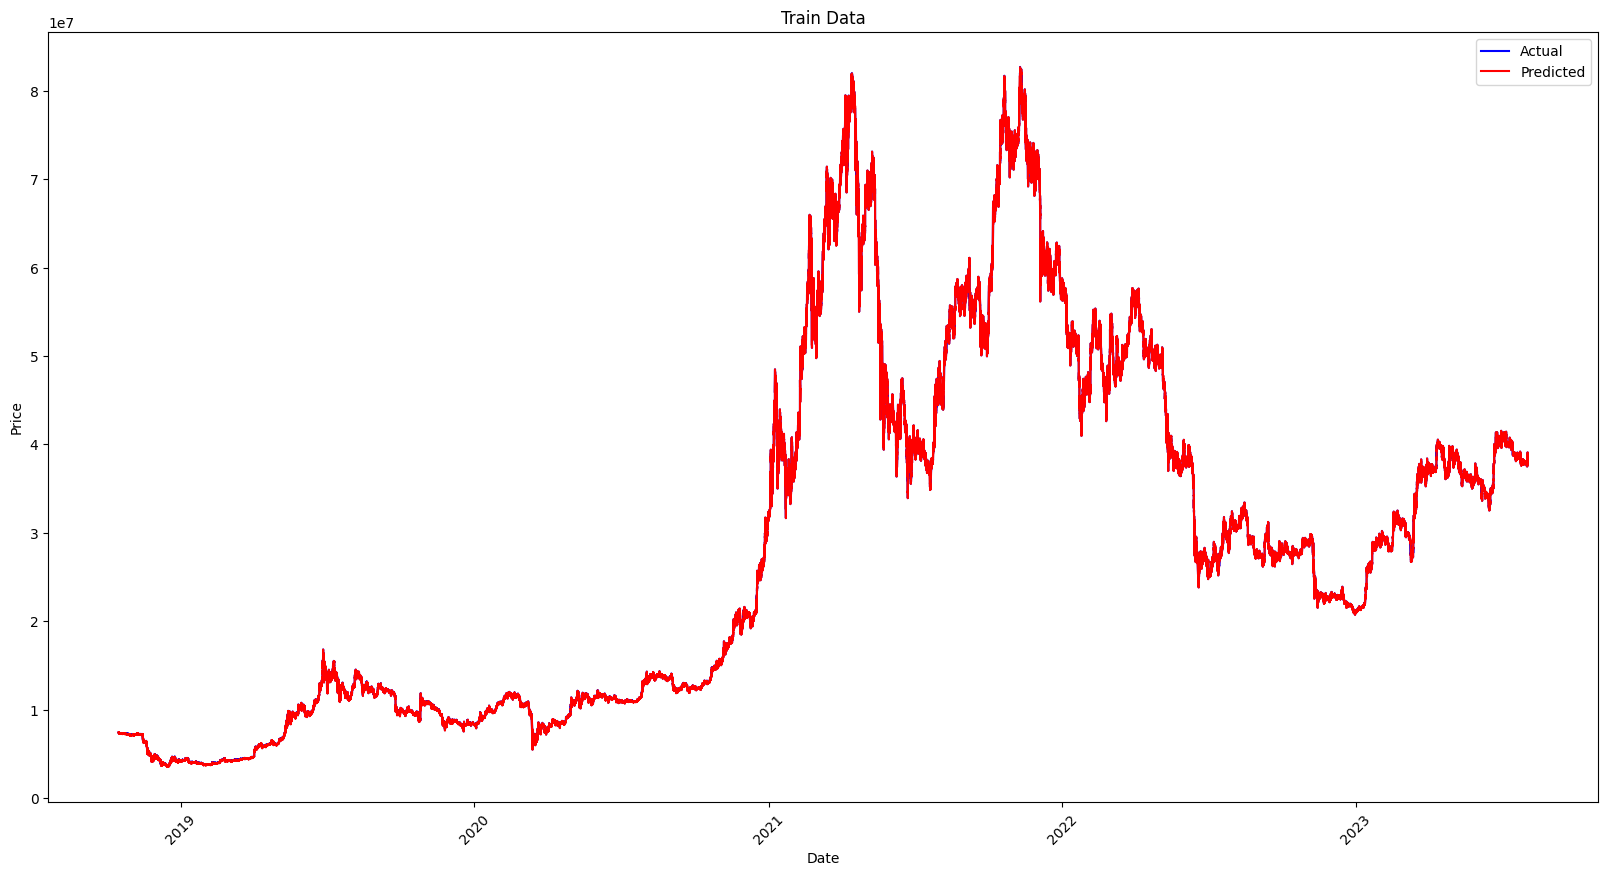

In [18]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

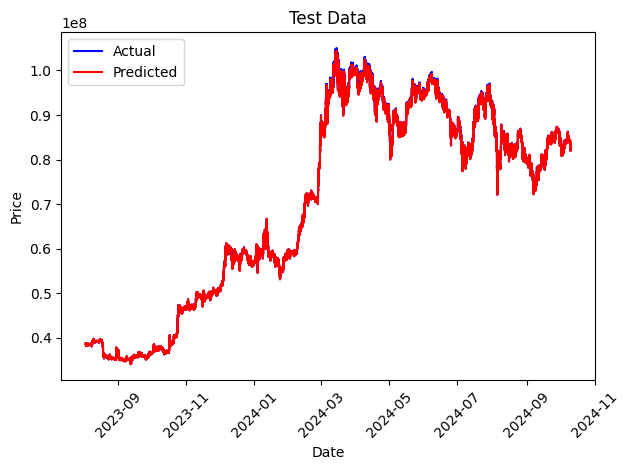

In [19]:
plt.subplot(1, 1, 1)
plt.plot(test_dates, y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates, test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [20]:
last_1_days = scaled_data[-timestep:]
X_predict = last_1_days.reshape(1, timestep, 1)

In [21]:
pred = model.predict(X_predict)
print(pred)

1/1 [==============================] - 0s 14ms/step
[[0.7815973]]


In [22]:
# Predict the future
# future_predictions = []
# for _ in range(len(new_df)):
#     pred = model.predict(X_predict)
#     future_predictions.append(pred[0, 0])
#     pred = pred.reshape(1, 1, 1)
#     X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))